<a href="https://colab.research.google.com/github/Efi-G-777/Lifts-Program/blob/main/CNN_Faust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm  # For progress tracking
import random
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping



In [3]:
# Directly define the path to the TRAIN folder
dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")

train_path = os.path.join(dataset_path, 'dataset2-master', 'dataset2-master', 'images', 'TRAIN')
test_path = os.path.join(dataset_path, 'dataset2-master', 'dataset2-master', 'images', 'TEST')

# List files in TRAIN folder
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
print("Files in TRAIN folder:", train_files)
print("Files in TEST folder:", test_files)

Files in TRAIN folder: ['LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE']
Files in TEST folder: ['LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE']


In [6]:
# Define categories
CATEGORIES = ['EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE']
IMG_SIZE = 64  # Resize images to 64 X 64

# Training data array
training_data = []

# Loop through categories
for category_index, category in enumerate(CATEGORIES):
    category_path = os.path.join(train_path, category)  # Path to category folder
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    # Loop through images in category
    # num = 0
    for img_file in tqdm(image_files, desc=f"Processing {category} [index:{category_index}]"):
        try:
            img_path = os.path.join(category_path, img_file)
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image (color)
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize to 64X64
            # if num < 1:
            #     plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            #     plt.show()
            #     num += 1
            training_data.append([img_array, category_index])  # Store image & label
        except Exception as e:
            print(f"Error processing {img_file}: {e}")  # Handle errors

print(f"\nTotal images processed: {len(training_data)}")



Processing LYMPHOCYTE [index:3]: 100%|██████████| 2483/2483 [00:01<00:00, 2060.88it/s]


Total images processed: 9957


In [7]:

# Shuffle the training data randomly
random.shuffle(training_data)

# Convert to NumPy arrays
X = []  # Image data
y = []  # Labels

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize pixel values (0-255 → 0-1)
y = np.array(y)

print(f"Dataset shuffled! Total images: {len(X)}")


Dataset shuffled! Total images: 9957


In [8]:

print("Shape of X:", X.shape)  # Should be (9957, 64, 64, 3)
print("Shape of y:", y.shape)  # Should be (9957,)
print("Unique labels:", np.unique(y))  # Should be [0, 1, 2, 3]


Y = to_categorical(y, num_classes=4)
print("Shape of Y:", Y.shape)  # Should be (9957, 4)



Shape of X: (9957, 64, 64, 3)
Shape of y: (9957,)
Unique labels: [0 1 2 3]
Shape of Y: (9957, 4)


In [9]:

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (7965, 64, 64, 3)
X_test shape: (1992, 64, 64, 3)
y_train shape: (7965, 4)
y_test shape: (1992, 4)


In [17]:


# Model Architecture with smaller input size (64x64)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv2D(256, (3,3), activation='relu', padding='same'),
    # MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 classes for output
])

# Compile Model
optimizer = 'adam' # (learning_rate=0.0001)   Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,468 (4.36 MB)

 Trainable params: 1,142,468 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 516ms/step - accuracy: 0.5518 - loss: 0.9884 - val_accuracy: 0.4769 - val_loss: 1.0709
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 634ms/step - accuracy: 0.5489 - loss: 0.9898 - val_accuracy: 0.5577 - val_loss: 1.0021
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 542ms/step - accuracy: 0.5745 - loss: 0.9257 - val_accuracy: 0.6124 - val_loss: 0.8378
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 479ms/step - accuracy: 0.6227 - loss: 0.8737 - val_accuracy: 0.6310 - val_loss: 0.8321
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 676ms/step - accuracy: 0.6245 - loss: 0.8166 - val_accuracy: 0.5728 - val_loss: 0.8700
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 481ms/step - accuracy: 0.6211 - loss: 0.8127 - val_accuracy: 0.6566 - val_loss: 0.7427
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 504ms/step - accuracy: 0.6254 - loss: 0.7889 - val_accuracy: 0.7144 - val_loss: 0.6977
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 505ms/step - accuracy: 0.6581 - loss: 0.7515 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - accuracy: 0.6404 - loss: 0.8311 - val_accuracy: 0.5969 - val_loss: 0.8506
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 504ms/step - accuracy: 0.6390 - loss: 0.8107 - val_accuracy: 0.6822 - val_loss: 0.6898
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.7105 - loss: 0.6760 - val_accuracy: 0.6702 - val_loss: 0.6979
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 683ms/step - accuracy: 0.7328 - loss: 0.6175 - val_accuracy: 0.7073 - val_loss: 0.6704
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step - accuracy: 0.7090 - loss: 0.6737 - val_accuracy: 0.7103 - val_loss: 0.6558
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 478ms/step - accuracy: 0.6456 - loss: 0.7058 - val_accuracy: 0.6320 - val_loss: 0.8357
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.6735 - loss: 0.7307 - val_accuracy: 0.7038 - val_loss: 0.6506
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.6909 - loss: 0.6764 - val_accuracy

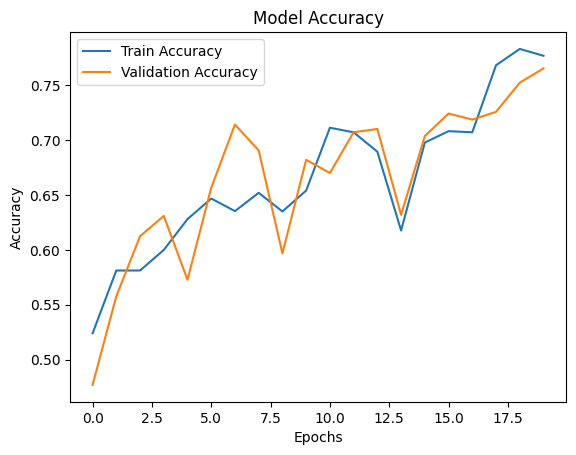

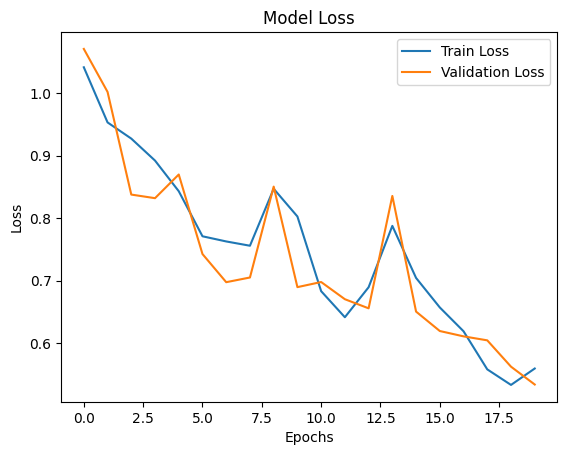

In [14]:
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------



# Define training parameters
batch_size = 32
epochs = 20

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    steps_per_epoch=30,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Plot the training and validation accuracy over epochs

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


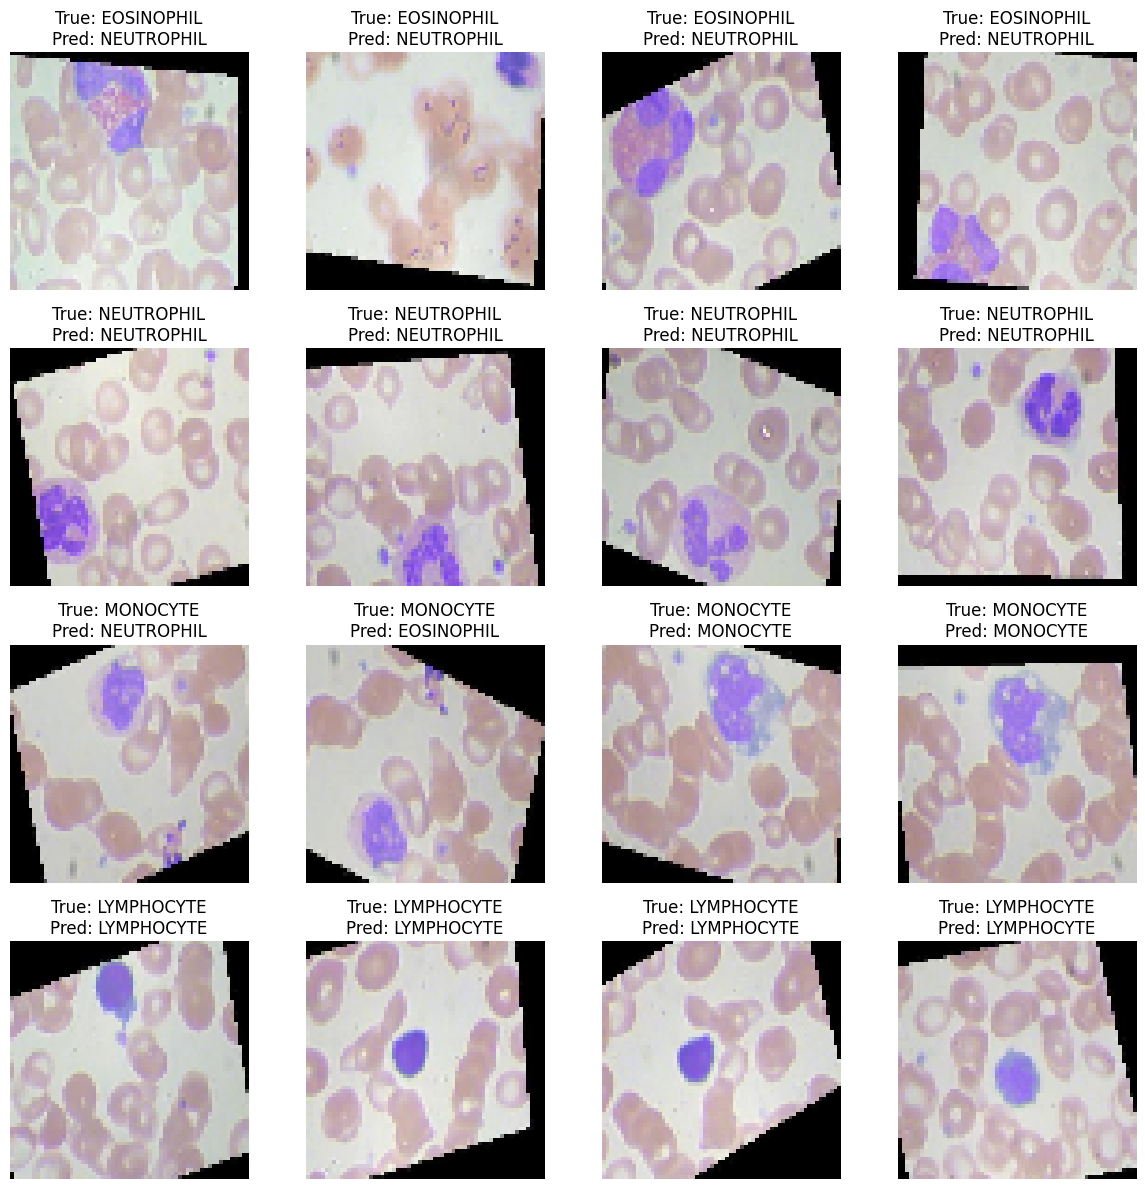

In [ ]:
# Define function to preprocess image for prediction
def preprocess_image(img_path):
    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE
    img_array = np.array(img_array, dtype=np.float32) / 255.0  # Normalize
    return img_array

# Randomly select 3 images from each category in the test set
selected_images = []
selected_labels = []

for category_index, category in enumerate(CATEGORIES):
    # Get all images in the current category
    category_path = os.path.join(test_path, category)
    category_images = [f for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    # Randomly select 3 images from this category
    random_images = random.sample(category_images, 4)

    for img_file in random_images:
        img_path = os.path.join(category_path, img_file)
        img_array = preprocess_image(img_path)
        selected_images.append(img_array)
        selected_labels.append(category_index)  # Store the true label

# Convert selected images to numpy array for predictions
selected_images = np.array(selected_images)
selected_images = selected_images.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # Reshape for model input

# Make predictions
predictions = model.predict(selected_images)

# Display images along with true and predicted labels
plt.figure(figsize=(12, 12))
for i in range(len(selected_images)):
    plt.subplot(4, 4, i + 1)  # 4 rows, 3 columns
    plt.imshow(cv2.cvtColor(selected_images[i], cv2.COLOR_BGR2RGB))
    true_label = CATEGORIES[selected_labels[i]]
    predicted_label = CATEGORIES[np.argmax(predictions[i])]

    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
